####이론

0. 자연어 처리 모델에서 사용하는 Transformer를 이미지 분류에 적용시킨 Vision Transformer에 관한 논문입니다.

1. 이미지를 patch 단위로 쪼개 '토큰화'시키고,
이들을 Linear Projection 과정(벡터화 과정)을 거쳐 Position Embedding시켜 순서를 부여한 뒤 Transformer Encoder의 입력으로 들어가게 됩니다.


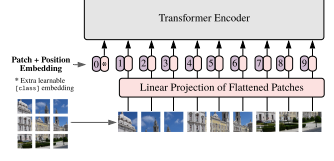

2. Transformer Encoder 내부에서는 먼저 Layer Normalization을 거치고, Multi-Head Attention을 지난 결과를 통과하지 않은 패치와 Skip Connection 시켜줍니다. 그리고 다시 Layer Nomalization, MLP를 거쳐 Skip Connection으로 다시 더해주는 것이 한 번 Transformer Encoder를 통과한 것입니다.
이러한 Transformer Encoder를 L번 반복합니다.

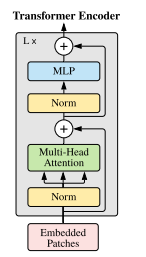

3. 만약 이미지가 (C,H,W) 크기


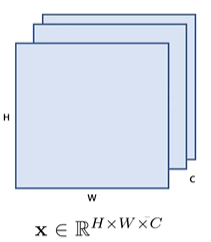
이며,



패치 사이즈가 (P,P)이면

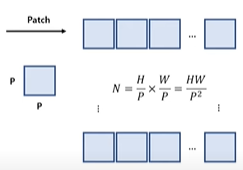



총 패치의 개수 N = HW/P^2 이고,

패치의 차원은

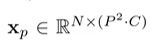

으로 이미지를 패치화합니다.

4. 각각의 n개의 patch를 D차원으로 벡터화하는데,그 결과가 n개의 xpE 입니다.

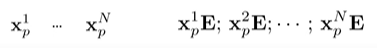



5. n개의 벡터에 Position Embedding을 시켜줘야 하는데 Epos를 더해 z0를 생성합니다.

image.png

6. z0가 Transformer Encoder 내부에서 1번 Encoding되는 과정은 다음과 같습니다.

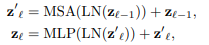

이러한 과정을 L번 반복합니다.

7. Encoding 과정을 L번 반복하고 그 결과값을 Layer Nomalization을 거치고 MLP head를 거쳐 softmax 결과에 따라 class로 나눠집니다.

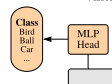


이 때, mlp head의 입력은 D차원 벡터이며
 (Transformer Encoder의 입출력 차원은 D차원이다),

####구현

구현할 모델에서는 Layer의 개수를 12개, D의 크기를 64, MLP의 크기를 1024, Head 개수를 4로 설정하여 진행한다.

In [ ]:
# tensorflow_addons를 사용하기 위해 설치해줘야 한다.
%pip install tensorflow_addons

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers          # vision transformer를 구성하는데 사용 (vit함수)
import tensorflow_addons as tfa

In [ ]:
print(tf.__version__)   # tensorflow 2.14.0 버전을 사용한다.

2.14.0


데이터는 cifar100을 사용한다.
32 x 32 크기의 60000개의 이미지로 이루어져 있으며, 100개의 클래스로 분류(dolphin, fish ...) 되며 각각의 클래스는 600개의 이미지로 이루어져 있다.
또, 500개는 학습 데이터, 100개는 데이터 데이터로 이루어져 있어 총 50000개의 학습 데이터, 10000개의 테스트 데이터로 이루어져있다.

In [ ]:
num_classes = 100         # cifar100 사용하므로 class를 100개로 지정
input_shape = (32,32,3)   # input shape는 32x32의 RGB 채널을 가진 이미지이다.

# 데이터 로드 (train과 test를 나눠서 로드한다)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape : {x_train.shape}, y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape}, y_test shape : {y_test.shape}")

x_train shape : (50000, 32, 32, 3), y_train shape : (50000, 1)
x_test shape : (10000, 32, 32, 3), y_test shape : (10000, 1)


In [ ]:
batch_size = 256

image_size = 224    # 16x16 이미지를 업사이징하여 224x224로 만들것이다.
patch_size = 32     # 패치 사이즈는 32x32,
num_patches = (image_size//patch_size)**2     # 패치의 개수는 이미지 크기를 패치사이즈로 나누고 제곱한다.

# D 차원으로 벡터화
projection_dim = 64   # D = 64
num_heads = 4

# mlp에서 사용하는 transformer unit (128, 64)
transformer_units = [
    projection_dim*2,
    projection_dim,
]

transformer_layers = 12         # layer의 개수
mlp_head_units = [2048, 1024]

In [ ]:
# 이미지 업사이징, 전처리
data_augmentation = keras.Sequential(
    [
            layers.Normalization(),                         # Normalize
            layers.Resizing(image_size, image_size),        # 224 x 224
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name = 'data_augmentation',
)

data_augmentation.layers[0].adapt(x_train)

In [ ]:
# mlp 함수
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
      x = layers.Dense(units, activation=tf.nn.gelu)(x)   # 활성화함수로 gelu를 사용
      x = layers.Dropout(dropout_rate)(x)                 # dropout을 사용한다.
  return x

In [ ]:
# 패치화하는 클래스
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images = images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        rates = [1,1,1,1],
        padding = "VALID",    # padding 사용 X
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072
Shape of patch: (1, 49, 3072)


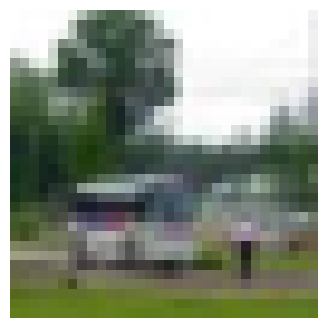

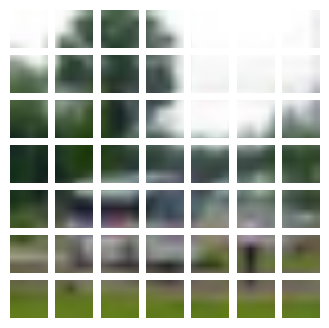

In [ ]:
import matplotlib.pyplot as plt

# 패치화 결과 확인
plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')
print(f'Shape of patch: {patches.shape}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype('uint8'))
  plt.axis('off')

In [ ]:
# PatchEncoder를 class로 정의
# (Linear Projection -> Position Embedding)
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches

    self.projection = layers.Dense(units=projection_dim)      # D차원으로 Linear Projection
    self.position_embedding = layers.Embedding(               # position embedding
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)          # 0부터 patch개수만큼 1씩 증가하는 position
    encoded = self.projection(patch) + self.position_embedding(positions)   # position embedding 과정
    return encoded  # z0

In [ ]:
# vision transformer
def vit():

  # 1) Patch화 ->  patch를 Linear Projection -> Position Embedding
  inputs = layers.Input(shape=input_shape)
  augmented = data_augmentation(inputs)     # inputs를 업사이징
  patches = Patches(patch_size)(augmented)  # patch 생성 (patches)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # patch를 Linear Projection -> Position Embedding


  # 2) Transformer Encoder L번 반복
  for _ in range(transformer_layers):   # L번 반복

    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)       # 1) Norm

    attention_output = layers.MultiHeadAttention(                       # 2) Multi-Head Attention
        num_heads = num_heads, key_dim = projection_dim, dropout=0.1
    )(x1, x1)

    x2 = layers.Add()([attention_output, encoded_patches])              # 3) Skip Connection

    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                    # 4) Norm

    x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)  # 5) MLP

    encoded_patches = layers.Add()([x3, x2])                            # 6) Skip Connection


  # 3) MLP Head에 들어가기 전 레이어정규화
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)


  # 4) MLP Head
  features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)


  # 5) class화
  logits = layers.Dense(num_classes)(features)


  # 6) 모델 생성
  model = keras.Model(inputs=inputs, outputs = logits)

  return model

In [ ]:
model = vit()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 224, 224, 3)          7         ['input_2[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_3 (Patches)         (None, None, 3072)           0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 49, 64)               199808    ['patches_3[0][0]']     

In [ ]:
# 학습 / 테스트
num_epochs = 20
weight_decay = 0.001
learning_rate = 0.001

optimizer = tfa.optimizers.AdamW(
    learning_rate = learning_rate, weight_decay = weight_decay
)

model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy'),
    ],
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs = num_epochs,
    validation_split = 0.1,
)

Epoch 1/20
176/176 [==============================] - 56s 188ms/step - loss: 4.2937 - accuracy: 0.0642 - top-5-accuracy: 0.2095 - val_loss: 3.7237 - val_accuracy: 0.1366 - val_top-5-accuracy: 0.3714
Epoch 2/20
176/176 [==============================] - 32s 184ms/step - loss: 3.7198 - accuracy: 0.1299 - top-5-accuracy: 0.3614 - val_loss: 3.3896 - val_accuracy: 0.1906 - val_top-5-accuracy: 0.4598
Epoch 3/20
176/176 [==============================] - 35s 200ms/step - loss: 3.4472 - accuracy: 0.1746 - top-5-accuracy: 0.4385 - val_loss: 3.1692 - val_accuracy: 0.2232 - val_top-5-accuracy: 0.5154
Epoch 4/20
176/176 [==============================] - 32s 180ms/step - loss: 3.2912 - accuracy: 0.2011 - top-5-accuracy: 0.4830 - val_loss: 3.0810 - val_accuracy: 0.2416 - val_top-5-accuracy: 0.5296
Epoch 5/20
176/176 [==============================] - 32s 181ms/step - loss: 3.1637 - accuracy: 0.2236 - top-5-accuracy: 0.5135 - val_loss: 2.9816 - val_accuracy: 0.2536 - val_top-5-accuracy: 0.5540
Epoch

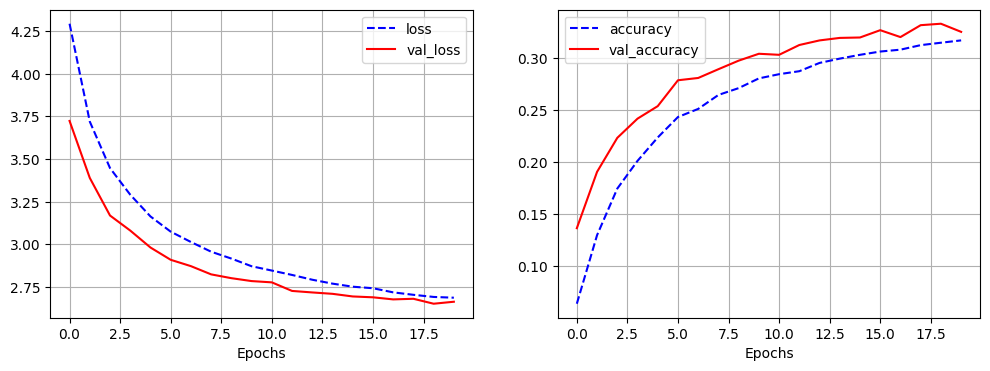

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
